Here, we only have two groups:
- Group2: the censored parts, for which we only know the number. $0 < y^* < l$.
- Group3: the observed parts, $y^* > l$.

In [41]:
import jax
import jaxopt
import jax.numpy as jnp
import pyreadr
import projplot as pjp
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [42]:
@jax.jit

def indicator(x):
    return(jnp.select([x>0,x<=0],[1,0]))

def logit(x):
    return(jnp.log(x/(1-x)))


def expit(x):
    return 1/(1+jnp.exp(-x))


def sigmoid(x, s):
    # x = jnp.array(x)
    # a = jnp.array(a)
    return 0.5 * (jnp.tanh(x * s / 2) + 1)

def dmgmodel_ind(y,alpha,l,c):
    return(y*indicator(c*y-l) + alpha*y*indicator(l-c*y))


def dmgmodel_py(y,alpha,l,c,s):
    #return(y*jax.scipy.stats.norm.cdf(c*y-l) + alpha*y*jax.scipy.stats.norm.cdf(l-c*y))
    return(y*sigmoid(c*y-l,s) + alpha*y*sigmoid(l-c*y,s))

    #return(y*g_smooth(c*y-l) + alpha*y*g_smooth(l-c*y))

def dmgmodel_root_py(y,alpha,l,c,s,ystar):
    return(dmgmodel_py(y,alpha,l,c,s) - ystar)



def dmginverse_py(ystar,alpha,l,c,s):
    ystar = jnp.array(ystar)
    bisec = jaxopt.Bisection(
        optimality_fun=dmgmodel_root_py,
        lower = 0,
        upper = 10000,
        check_bracket = False)
    return(bisec.run(alpha = alpha,l = l, c= c ,s = s,ystar = ystar).params)

def dmginvgrad_py(ystar,alpha,l,c,s):
    grad_func = jax.grad(dmginverse_py,0)
    return(jnp.abs(grad_func(ystar,alpha,l,c,s)))

def dmglik_py(ystar,alpha,l,c,s,mu,sigma):
    y =  dmginverse_py(ystar,alpha,l,c,s)
    return(jax.scipy.stats.norm.logpdf(y,loc = mu,scale = sigma)+ 
           jnp.log(dmginvgrad_py(ystar,alpha,l,c,s))
          )


def dmglik_vmap(y_group,alpha,l,c,s,mu,sigma):
    y_group = jnp.array(y_group)
    lik = jax.vmap(lambda y_group: dmglik_py(ystar = y_group,
                                             alpha = alpha,l = l, c= c,s =s,mu = mu, sigma=sigma))(y_group)
    return(jnp.sum(lik))



In [43]:
# the orignal sample size 
#N = 30000
N = 300
mu = 48
sigma = 19
l =  32
alpha = 0.25
c = 0.65
s = 10

N_marginal = 139





In [44]:
# data generation 
key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, num=N)

y = sigma*jax.random.normal(subkeys[1], shape=(N, )) + mu
y = y[y>0]

y_obs = jax.vmap(lambda y: dmgmodel_py(y,alpha,l,c,s))(y)

y_group2 = jnp.shape(y_obs[y_obs < l ])[0]
y_group3 = y_obs[y_obs > l ]



In [61]:
y_group3

Array([ 93.24034 ,  61.578606,  83.37561 ,  64.6907  ,  57.91359 ,
        53.825813,  52.193424,  59.73144 ,  55.585083,  55.81493 ,
        58.005898,  54.897278,  69.18673 ,  53.022915,  62.85026 ,
        50.933777,  52.07268 ,  67.04619 ,  68.98906 ,  53.144356,
        86.58693 ,  53.027786,  56.305202,  61.371532,  56.15706 ,
        85.37813 ,  60.006336,  62.672794,  76.82298 ,  56.22699 ,
        63.1154  ,  56.849136,  52.408886,  55.764694,  67.37969 ,
        65.482346,  64.92102 ,  78.97485 ,  60.620937,  75.902725,
        60.432507,  53.51707 ,  59.6509  ,  72.25659 ,  52.477783,
        49.72653 ,  55.415443,  76.325294,  37.431828,  60.42426 ,
        57.165016,  58.887814,  74.56699 ,  49.8216  ,  52.36245 ,
        53.23481 ,  48.036278,  61.628815,  69.484116,  61.617313,
        53.124256,  52.952156,  56.155655,  92.32299 ,  58.331406,
        51.29017 ,  50.463715,  73.96784 ,  71.57753 ,  67.907684,
        63.737747,  59.62616 ,  53.644825,  72.03316 ,  52.109

In [53]:
s= s
l = l 

@jax.jit
def negdmglik_jax(theta):
    mu = 48
    sigma = 19
    alpha = theta
    c = 0.65
    lik2 = y_group2*jnp.log(
        jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
        jax.scipy.stats.norm.cdf(dmginverse_py(1e-6,alpha,l,c,s), loc=mu, scale=sigma)
        )
    lik3 = dmglik_vmap(y_group = y_group3,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)

    return(-lik2-lik3)

#theta0 = jnp.array([alpha])
negdmglik_jax(alpha)

Array(747.5725, dtype=float32)

In [54]:


solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax)
res = solver.run(alpha)

# solver = jaxopt.BFGS(fun=negdmglik_jax)
# res = solver.run(theta0)

res.params,res.state
theta0

(Array(0.3734375, dtype=float32),
 ScipyMinimizeInfo(fun_val=Array(747.55786, dtype=float32), success=True, status=0, iter_num=13, hess_inv=None))

Array([0.25], dtype=float32)

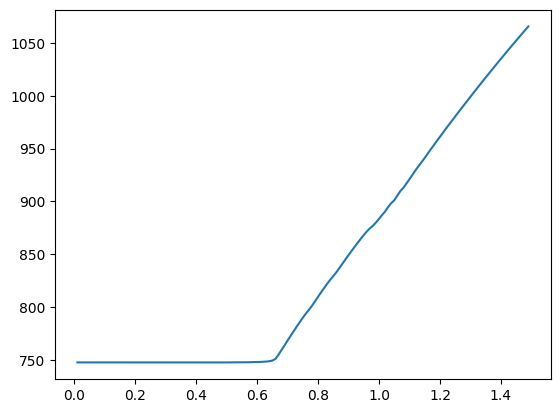

In [55]:
alpha_seq = jnp.arange(0.01, 1.5,0.01)
lik_seq = jax.vmap(negdmglik_jax)(alpha_seq )
plt.plot(alpha_seq,lik_seq)

In [60]:
negdmglik_jax(.1)
negdmglik_jax(.3)


dmglik_vmap(y_group = y_group3,alpha = .1,l = l, c = c,s = s, mu = mu, sigma = sigma)
dmglik_vmap(y_group = y_group3,alpha = .3,l = l, c = c,s = s, mu = mu, sigma = sigma)

Array(747.60815, dtype=float32)

Array(747.56366, dtype=float32)

Array(-647.99927, dtype=float32)

Array(-647.5309, dtype=float32)

In [48]:
# xsol = res.params
# xrange = .5
# theta_upper = xsol  + xrange *jnp.abs(xsol)
# theta_lower = xsol - xrange * jnp.abs(xsol)
# theta_rng_trans = jnp.array([theta_lower, theta_upper])

# #res.params
# theta_rng = jnp.transpose(theta_rng_trans)
# theta_rng
# # plot at the true value theta0
# pjp.proj_plot(
#     fun=negdmglik_jax,
#     x_opt=xsol,
#     x_lims=theta_rng, 
#     n_pts=100, 
#     x_names= ['mu','sigma','alpha'],
#     opt_vlines=True
# )